### Импорт библиотек

In [1]:
import pandas as pd

### Импорт данных

In [3]:
data = pd.read_csv('data.csv')
data.sample(3)

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
1299,1300,28.0,7.7208,1,0,0,0,0,0,0,...,0,0,0,3,0,0,1.0,0,0,0
825,826,28.0,6.9500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1.0,0,0,0
781,782,17.0,57.0000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1


### Загрузка данных в БД
После загрузки данных из любого формата, нас могут попросить загрузить данные в БД. Представляем в любом случае таблицу в виде DataFrame. [Источник](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html)

Обязательно предусматриваем исключения.

In [4]:
import sqlite3

def save_table(df, table_name):
  try:
    conn = sqlite3.connect('db.db')
    df.to_sql(table_name, con=conn, if_exists='replace', index=False)
    print(f'Таблица "{table_name}" успешно сохранена')
  except Exception as e:
    print('Ошибка загрузки данных в БД: ', e)

In [5]:
save_table(data, 'titanic')

Таблица "titanic" успешно сохранена


Для нереляционных данных, если нет возможности представить их в таблицу или в задании просят использовать NoSQL базы данных (как Mongo и др.), используем shelve. [Источник.](https://docs.python.org/3/library/shelve.html#example)

In [7]:
import shelve

db = shelve.open('nosql_db')

db['data'] = data

db.close()

## Предобработка данных

Для дальнейшнего анализа нам нужно поработать с данными. Айди сразу выкидываем, пока нам будет достаточно числовых столбцов.

In [19]:
data = data.select_dtypes(include=['number'])

data = data.drop(['Passengerid'], axis=1)

data.sample(3)

,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,zero.5,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
47,28.0,7.750,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,1.0,0,0,1
751,6.0,12.475,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
1164,28.0,15.500,1,1,0,0,0,0,0,0,...,0,0,0,3,0,0,1.0,0,0,0


Также необходимо заполнить пропуски.

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

transformed_data = imputer.fit_transform(data)

preprocess_data = pd.DataFrame(transformed_data, columns=data.columns)
preprocess_data.sample(3)

,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,zero.5,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
1108,57.0,164.8667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
700,18.0,227.5250,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
368,28.0,7.7500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0


И проанализировать выбросы (если потребуется).

<Axes: ylabel='Fare'>

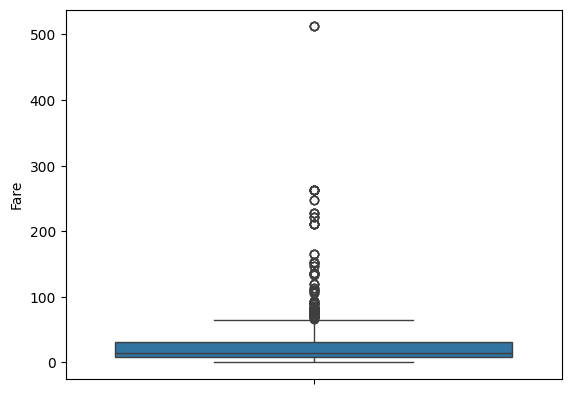

In [31]:
# На примере 1 признака
import seaborn as sns

sns.boxplot(preprocess_data['Fare'])

<Axes: ylabel='Fare'>

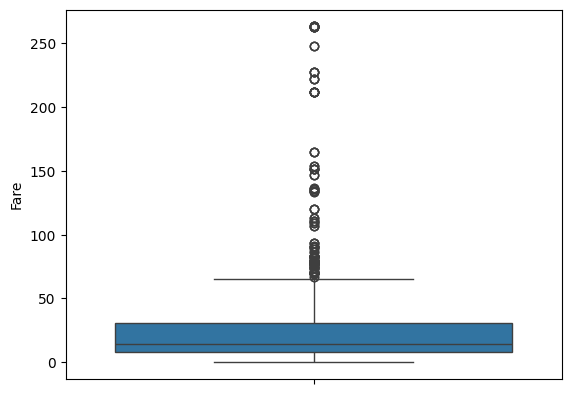

In [33]:
preprocess_data = preprocess_data[preprocess_data['Fare'] < 300]
sns.boxplot(preprocess_data['Fare'])

Всегда должна быть аргументация удаления признаков и строк в датасете.

## Кластеризация данных

Может быть такая формулировка задания:

*Для представленного набора данных предполагается применить методы кластерного анализа для создания групп, схожих по характеристикам. Такие кластеры в будущем помогут выявить динамику зависимости различных параметров для ...*

<Axes: >

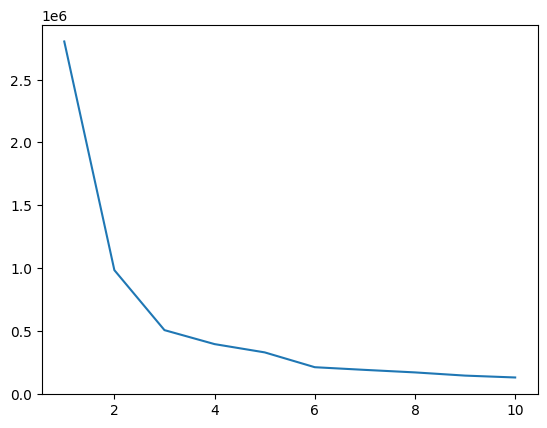

In [37]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# По методу локтя определим оптимальное кол-во кластеров

l = []
for i in range(1, 11):
  model = KMeans(n_clusters=i)
  model.fit(preprocess_data)
  l.append(model.inertia_)


sns.lineplot(x=range(1, 11), y=l)

Но самый стабильный показатель суммы квадратов внутрикластерной дисперсии перестает критически падать после 3 кластеров, обучим модель кластеризации.

In [42]:
model = KMeans(n_clusters=3)
model.fit(preprocess_data)

preprocess_data.loc[:, 'label'] = model.labels_
preprocess_data.sample(3)

,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,zero.5,...,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived,label
735,28.5,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2
506,33.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2
1235,28.0,14.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2


На основе этих меток в дальнейшем будет делать отбор признаков.

## Анализ признаков

Для демонстрации берем 3 признака.

Для каждого атрибута подготовим:
1. Описание, содержащее текстовое представление (расшифровка, перевод, назначение)
2. Анализ плотности данных.
3. Выполнить проверку нормальности распределения значений в атрибутах.
4. Для определения отклонений от нормы провести графическую и статистические оценки.
5. На основе полученных результатов сделать вывод о типе распределения и мере скошенности.

Для анализа плотности значений используем KDE-график.

Для графической оценки отклонений от нормальности строю гистограмму и QQ-Plot.
Эти графики наглядно показывают отклонения от нормального распределения, а также помогут определить аномалии и скошенности.

Для статистической оценки тест Шапиро-Уаилка, а также замеряем ассиметрию и эксцесс, которые помогут определить тип распредления меру скошенности.

Признак: Age
Описание: Возраст
Тест Шапиро-Уилка: статистика=0.9507, p-value=0.0000
Асимметрия (skewness): 0.5433
Эксцесс (kurtosis): 0.9788
Распределение отличается от нормального (p <= 0.05)
Вывод: умеренная асимметрия, островершинное (острые пики и тяжёлые хвосты).


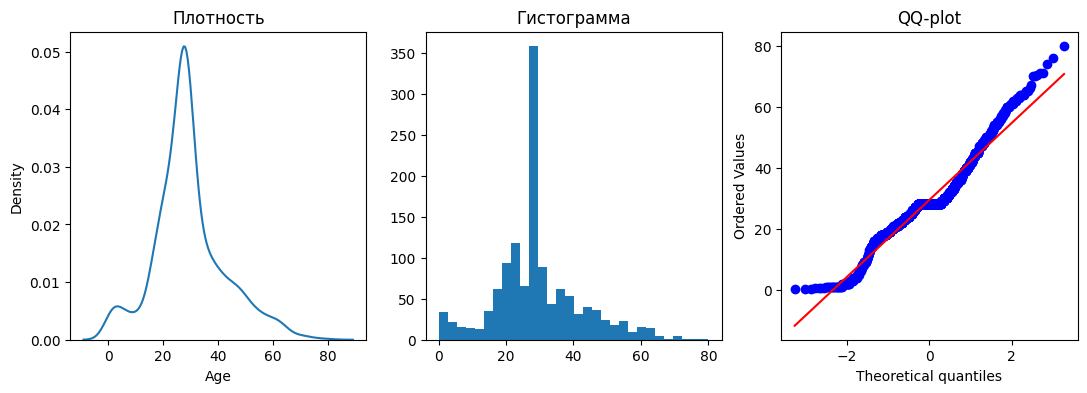

Признак: Fare
Описание: Состояние
Тест Шапиро-Уилка: статистика=0.5877, p-value=0.0000
Асимметрия (skewness): 3.1584
Эксцесс (kurtosis): 11.1368
Распределение отличается от нормального (p <= 0.05)
Вывод: выраженная асимметрия, островершинное (острые пики и тяжёлые хвосты).


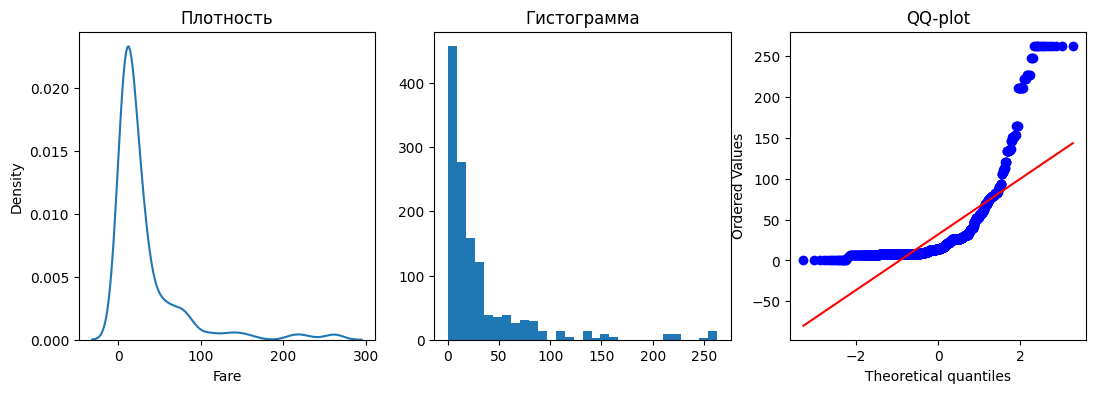

Признак: Sex
Описание: Пол
Тест Шапиро-Уилка: статистика=0.6055, p-value=0.0000
Асимметрия (skewness): 0.6042
Эксцесс (kurtosis): -1.6374
Распределение отличается от нормального (p <= 0.05)
Вывод: умеренная асимметрия, плосковершинное (плоские пики и лёгкие хвосты).


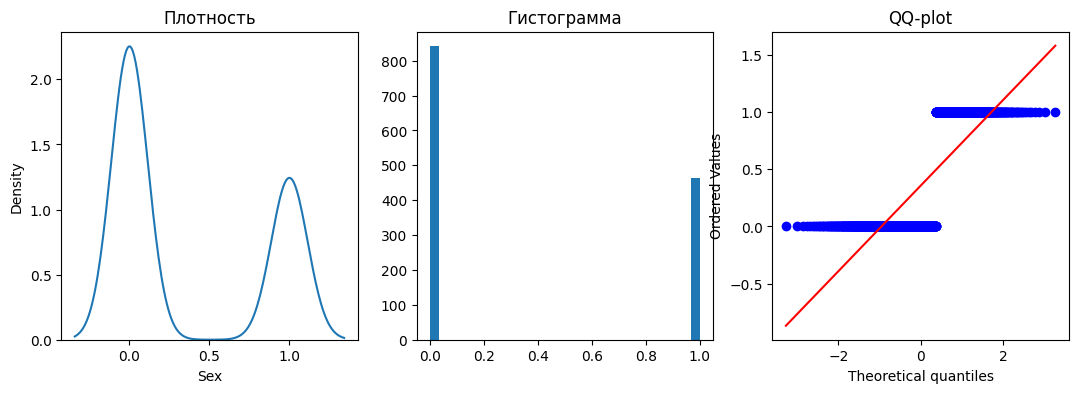

In [90]:
from scipy import stats

cols = {
    'Age': 'Возраст',
    'Fare': 'Состояние',
    'Sex': 'Пол'
}

for col in cols:
  print(f'Признак: {col}\nОписание: {cols[col]}')
  fig, axs = plt.subplots(1, 3, figsize=(13, 4))

  sns.kdeplot(preprocess_data[col], ax=axs[0])
  axs[0].set_title('Плотность')
  axs[1].hist(preprocess_data[col], bins=30)
  axs[1].set_title('Гистограмма')
  stats.probplot(preprocess_data[col], plot=axs[2])
  axs[2].set_title('QQ-plot')

  # Статистические тесты
  stat, p_value = stats.shapiro(preprocess_data[col])
  print(f"Тест Шапиро-Уилка: статистика={stat:.4f}, p-value={p_value:.4f}")

  # Меры skewness и kurtosis
  skewness = preprocess_data[col].skew()
  kurtosis = preprocess_data[col].kurt()
  print(f"Асимметрия (skewness): {skewness:.4f}")
  print(f"Эксцесс (kurtosis): {kurtosis:.4f}")

  if p_value > 0.05:
        print("Распределение нормальное (p > 0.05)")
  else:
        print("Распределение отличается от нормального (p <= 0.05)")

  # === Вывод о типе распределения ===
  if abs(skewness) < 0.5:
      skew_desc = "распределение близко к симметричному"
  elif 0.5 <= abs(skewness) < 1:
      skew_desc = "умеренная асимметрия"
  else:
      skew_desc = "выраженная асимметрия"

  if kurtosis > 0:
      kurt_desc = "островершинное (острые пики и тяжёлые хвосты)"
  elif kurtosis < 0:
      kurt_desc = "плосковершинное (плоские пики и лёгкие хвосты)"
  else:
      kurt_desc = "нормальная остроконечность"

  print(f"Вывод: {skew_desc}, {kurt_desc}.")


  plt.show()

Мы получили вывод исходя из статистик, анализируя графики, можно подтвердить эти данные.

## SQL-запросы

К нашей БД могут попросить сделать разные запроси, типо таких. Тут надо значит синтаксис SQL.

1.	Общая загруженность станции
2.	Пропускная способность в процентах по отношению к средней пропускной способности
3.	Количественные характеристики входного и выходного оборудования
4.	Временные интервалы поездки
5.	Продолжительность поездки


In [94]:
# Пример запроса
conn = sqlite3.connect('db.db')
pd.read_sql(con=conn, sql='select * from titanic').head(3)

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1


## Формирование итогового набора данных


Тут, возможно, попросят как-то переделать датасет в новый формат, потом сохраняем новую таблицу в БД.

In [95]:
save_table(preprocess_data, 'titanic_preprocess')

Таблица "titanic_preprocess" успешно сохранена
